In [ ]:
!pip install torch  pytorch-lightning nltk scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 17.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence





# Descargar los recursos necesarios de NLTK
nltk.download('wordnet') # base lexica en ingles para lematizacion
nltk.download('omw-1.4') #proporciona soporte para multilengua wordnet
nltk.download('punkt')
nltk.download('stopwords')


# Cargar dataset
data = pd.read_csv('/content/drive/MyDrive/MAESTRIA IA/NLP/lab2/train.tsv', sep='\t')
#data = pd.read_csv('train.tsv', sep='\t')

rand_seed = 13

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# lab2

In [ ]:
# Tokenización
data['tokens'] = data['Phrase'].apply(word_tokenize)

print(data['tokens'][0])

vectorizer = CountVectorizer()


# BAG OF WORDS
# Transformar el texto en una matriz de características
X = vectorizer.fit_transform(data['Phrase'])

# Ver las características creadas
print(X.shape)  # Número de frases x número de características

# visualizar matriz en un DataFrame
X_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

X_train, X_test, y_train, y_test = train_test_split(X, data['Sentiment'], test_size=0.2, random_state=rand_seed)

# Definir el modelo de Naive Bayes
model = MultinomialNB()

# Entrenar el modelo
model.fit(X_train, y_train)

# Evaluar el modelo
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))



['A', 'series', 'of', 'escapades', 'demonstrating', 'the', 'adage', 'that', 'what', 'is', 'good', 'for', 'the', 'goose', 'is', 'also', 'good', 'for', 'the', 'gander', ',', 'some', 'of', 'which', 'occasionally', 'amuses', 'but', 'none', 'of', 'which', 'amounts', 'to', 'much', 'of', 'a', 'story', '.']
(156060, 15240)
Accuracy: 0.6122645136485967
              precision    recall  f1-score   support

           0       0.44      0.32      0.37      1397
           1       0.49      0.45      0.47      5437
           2       0.70      0.77      0.73     15853
           3       0.53      0.51      0.52      6689
           4       0.48      0.33      0.39      1836

    accuracy                           0.61     31212
   macro avg       0.53      0.47      0.50     31212
weighted avg       0.60      0.61      0.60     31212



# RNN

In [ ]:

# Configuraciones
BATCH_SIZE = 64
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = 3
N_EPOCHS = 30
MAX_SEQ_LEN = 50

# Dataset y Preprocesamiento
class SentimentDataset(Dataset):
    def __init__(self, dataframe, vocab=None):
        self.texts = dataframe['Phrase'].values
        self.labels = dataframe['Sentiment'].values
        self.stop_words = set(stopwords.words('english'))

        if vocab is None:
            self.vocab = self.build_vocab(self.texts)
        else:
            self.vocab = vocab

        self.label_encoder = LabelEncoder()

        # Mapear las etiquetas originales a las nuevas clases (0: negativa, 1: neutral, 2: positiva)
        self.labels = self.map_labels(self.labels)

    def build_vocab(self, texts):
        vocab = set()
        for text in texts:
            tokens = word_tokenize(text.lower())
            vocab.update([word for word in tokens if word.isalpha() and word not in self.stop_words])
        return {word: i + 1 for i, word in enumerate(vocab)}

    def map_labels(self, labels):
        # Agrupar las clases originales en 3: negativa (0,1), neutral (2), positiva (3,4)
        return np.array([0 if label in [0, 1] else 1 if label == 2 else 2 for label in labels])

    def text_to_sequence(self, text):
        tokens = word_tokenize(text.lower())
        return [self.vocab.get(word, 0) for word in tokens if word.isalpha() and word not in self.stop_words]

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        seq = self.text_to_sequence(text)
        return torch.tensor(seq, dtype=torch.long), torch.tensor(label, dtype=torch.long)


class SentimentRNN(pl.LightningModule):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, label_encoder, n_layers=2, dropout=0.5, bidirectional=True):
        super(SentimentRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=n_layers, dropout=dropout,
                          batch_first=True, bidirectional=bidirectional)

        self.fc = nn.Linear(hidden_dim * 2 , output_dim)
        self.dropout = nn.Dropout(dropout)
        self.loss_fn = nn.CrossEntropyLoss()
        self.label_encoder = label_encoder

        self.all_preds = []
        self.all_labels = []

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, hidden = self.rnn(embedded)

        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        else:
            hidden = self.dropout(hidden[-1,:,:])

        return self.fc(hidden)

    def training_step(self, batch, batch_idx):
        texts, labels = batch
        preds = self(texts)
        loss = self.loss_fn(preds, labels)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        texts, labels = batch
        preds = self(texts)
        loss = self.loss_fn(preds, labels)
        self.log('val_loss', loss, prog_bar=True)
        preds = torch.argmax(preds, dim=1)
        self.all_preds.append(preds)
        self.all_labels.append(labels)
        return loss

    def on_train_end(self):
        # Al final del entrenamiento, concatenamos todas las predicciones y etiquetas
        all_preds = torch.cat(self.all_preds)
        all_labels = torch.cat(self.all_labels)

        f1 = f1_score(all_labels.cpu(), all_preds.cpu(), average='weighted')
        acc = accuracy_score(all_labels.cpu(), all_preds.cpu())

        # Añade la matriz de confusión y reporte de clasificación
        conf_matrix = confusion_matrix(all_labels.cpu(), all_preds.cpu())

        # Definimo los nombres de las clases
        class_names = ['negative', 'neutral', 'positive']
        class_report = classification_report(all_labels.cpu(), all_preds.cpu(), target_names=class_names)

        print("Final Classification Report:\n", class_report)
        print(f"Final F1 Score: {f1}, Accuracy: {acc}")

        # Graficar la matriz de confusión
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

    def test_step(self, batch, batch_idx):
        texts, labels = batch
        preds = self(texts)
        loss = self.loss_fn(preds, labels)
        preds = torch.argmax(preds, dim=1)
        acc = accuracy_score(labels.cpu(), preds.cpu())
        f1 = f1_score(labels.cpu(), preds.cpu(), average='weighted')
        self.log('test_loss', loss)
        self.log('test_accuracy', acc)
        self.log('test_f1', f1)
        return {"test_loss": loss, "test_accuracy": acc, "test_f1": f1}

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.001)


def collate_fn(batch):
    texts, labels = zip(*batch)
    texts = [t[:MAX_SEQ_LEN].clone().detach().long() for t in texts]
    padded_texts = pad_sequence(texts, batch_first=True)
    labels = torch.tensor(labels, dtype=torch.long)
    return padded_texts, labels



df = data

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | embedding | Embedding        | 1.5 M  | train
1 | rnn       | RNN              | 157 K  | train
2 | fc        | Linear           | 771    | train
3 | dropout   | Dropout          | 0      | train
4 | loss_fn   | CrossEntropyLoss | 0      | train
-------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.445     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


Final Classification Report:
               precision    recall  f1-score   support

    negative       0.70      0.56      0.62    164876
     neutral       0.71      0.82      0.76    382056
    positive       0.74      0.64      0.69    202266

    accuracy                           0.71    749198
   macro avg       0.72      0.67      0.69    749198
weighted avg       0.72      0.71      0.71    749198

Final F1 Score: 0.7098149176575697, Accuracy: 0.7140729153040986


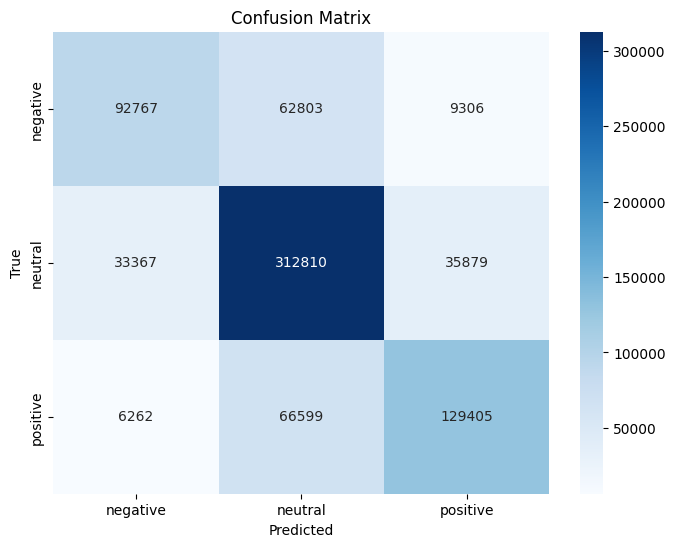

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.7409899234771729     │
│          test_f1          │    0.7392363548278809     │
│         test_loss         │    0.6737214922904968     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6737214922904968, 'test_accuracy': 0.7409899234771729, 'test_f1': 0.7392363548278809}]


In [ ]:



train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['Sentiment'], random_state=rand_seed)
val_df, test_df = train_test_split(temp_df, test_size=0.2, stratify=temp_df['Sentiment'], random_state=rand_seed)

train_dataset = SentimentDataset(train_df)
val_dataset = SentimentDataset(val_df, vocab=train_dataset.vocab)
test_dataset = SentimentDataset(test_df, vocab=train_dataset.vocab)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=0)

# Pasamos el label_encoder desde el dataset
model = SentimentRNN(vocab_size=len(train_dataset.vocab) + 1,
                     embedding_dim=EMBEDDING_DIM,
                     hidden_dim=HIDDEN_DIM,
                     output_dim=OUTPUT_DIM,
                     label_encoder=train_dataset.label_encoder,
                     n_layers=2,
                     dropout=0.5,
                     bidirectional=True)

trainer = pl.Trainer(max_epochs=N_EPOCHS, devices=1 if torch.cuda.is_available() else 0)
trainer.fit(model, train_loader, val_loader)


test_results = trainer.test(model, dataloaders=test_loader)
print(test_results)


# LSTM

In [ ]:
# Configuraciones
BATCH_SIZE = 64
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = 3
N_EPOCHS = 30
MAX_SEQ_LEN = 50

# Dataset y Preprocesamiento
class SentimentDataset(Dataset):
    def __init__(self, dataframe, vocab=None):
        self.texts = dataframe['Phrase'].values
        self.labels = dataframe['Sentiment'].values
        self.stop_words = set(stopwords.words('english'))

        if vocab is None:
            self.vocab = self.build_vocab(self.texts)
        else:
            self.vocab = vocab

        self.label_encoder = LabelEncoder()

        # Mapear las etiquetas originales a las nuevas clases (0: negativa, 1: neutral, 2: positiva)
        self.labels = self.map_labels(self.labels)

    def build_vocab(self, texts):
        vocab = set()
        for text in texts:
            tokens = word_tokenize(text.lower())
            vocab.update([word for word in tokens if word.isalpha() and word not in self.stop_words])
        return {word: i + 1 for i, word in enumerate(vocab)}

    def map_labels(self, labels):
        # Agrupar las clases originales en 3: negativa (0,1), neutral (2), positiva (3,4)
        return np.array([0 if label in [0, 1] else 1 if label == 2 else 2 for label in labels])

    def text_to_sequence(self, text):
        tokens = word_tokenize(text.lower())
        return [self.vocab.get(word, 0) for word in tokens if word.isalpha() and word not in self.stop_words]

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        seq = self.text_to_sequence(text)
        return torch.tensor(seq, dtype=torch.long), torch.tensor(label, dtype=torch.long)

# Model: Adaptado para PyTorch Lightning con LSTM
class SentimentRNN(pl.LightningModule):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=2, dropout=0.5, bidirectional=True):
        super(SentimentRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, dropout=dropout,
                           batch_first=True, bidirectional=bidirectional)

        self.fc = nn.Linear(hidden_dim * 2 , output_dim)
        self.dropout = nn.Dropout(dropout)
        self.loss_fn = nn.CrossEntropyLoss()

        self.all_preds = []
        self.all_labels = []

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, (hidden, cell) = self.rnn(embedded)

        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        else:
            hidden = self.dropout(hidden[-1,:,:])

        return self.fc(hidden)

    def training_step(self, batch, batch_idx):
        texts, labels = batch
        preds = self(texts)
        loss = self.loss_fn(preds, labels)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        texts, labels = batch
        preds = self(texts)
        loss = self.loss_fn(preds, labels)
        self.log('val_loss', loss, prog_bar=True)
        preds = torch.argmax(preds, dim=1)
        self.all_preds.append(preds)
        self.all_labels.append(labels)
        return loss

    def on_train_end(self):
        # Al final del entrenamiento, concatenamos todas las predicciones y etiquetas
        all_preds = torch.cat(self.all_preds)
        all_labels = torch.cat(self.all_labels)

        f1 = f1_score(all_labels.cpu(), all_preds.cpu(), average='weighted')
        acc = accuracy_score(all_labels.cpu(), all_preds.cpu())

        # Añade la matriz de confusión y reporte de clasificación
        conf_matrix = confusion_matrix(all_labels.cpu(), all_preds.cpu())

        # Definimos manualmente los nombres de las clases
        class_names = ['negative', 'neutral', 'positive']
        class_report = classification_report(all_labels.cpu(), all_preds.cpu(), target_names=class_names)

        print("Final Classification Report:\n", class_report)
        print(f"Final F1 Score: {f1}, Accuracy: {acc}")

        # Graficar la matriz de confusión
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

    def test_step(self, batch, batch_idx):
        texts, labels = batch
        preds = self(texts)
        loss = self.loss_fn(preds, labels)
        preds = torch.argmax(preds, dim=1)
        acc = accuracy_score(labels.cpu(), preds.cpu())
        f1 = f1_score(labels.cpu(), preds.cpu(), average='weighted')
        self.log('test_loss', loss)
        self.log('test_accuracy', acc)
        self.log('test_f1', f1)
        return {"test_loss": loss, "test_accuracy": acc, "test_f1": f1}

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.001)

# Collate function to handle padding
def collate_fn(batch):
    texts, labels = zip(*batch)
    texts = [t[:MAX_SEQ_LEN].clone().detach().long() for t in texts]
    padded_texts = pad_sequence(texts, batch_first=True)
    labels = torch.tensor(labels, dtype=torch.long)
    return padded_texts, labels

# Datos de prueba (sustituye 'data' por tu dataframe real)
df = data

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | embedding | Embedding        | 1.5 M  | train
1 | rnn       | LSTM             | 630 K  | train
2 | fc        | Linear           | 771    | train
3 | dropout   | Dropout          | 0      | train
4 | loss_fn   | CrossEntropyLoss | 0      | train
-------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.337     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


Final Classification Report:
               precision    recall  f1-score   support

    negative       0.72      0.62      0.67    164876
     neutral       0.73      0.82      0.77    382056
    positive       0.76      0.68      0.72    202266

    accuracy                           0.73    749198
   macro avg       0.74      0.70      0.72    749198
weighted avg       0.73      0.73      0.73    749198

Final F1 Score: 0.7312136565636983, Accuracy: 0.7336979009554216


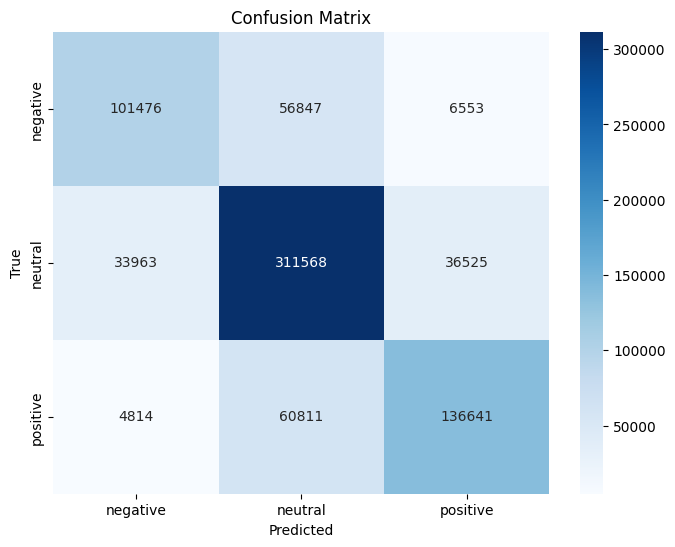

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.749159038066864     │
│          test_f1          │    0.7482913732528687     │
│         test_loss         │    0.6586377620697021     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6586377620697021, 'test_accuracy': 0.749159038066864, 'test_f1': 0.7482913732528687}]


In [ ]:


train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['Sentiment'], random_state=rand_seed)
val_df, test_df = train_test_split(temp_df, test_size=0.2, stratify=temp_df['Sentiment'], random_state=rand_seed)

train_dataset = SentimentDataset(train_df)
val_dataset = SentimentDataset(val_df, vocab=train_dataset.vocab)
test_dataset = SentimentDataset(test_df, vocab=train_dataset.vocab)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=0)

model = SentimentRNN(vocab_size=len(train_dataset.vocab) + 1,
                     embedding_dim=EMBEDDING_DIM,
                     hidden_dim=HIDDEN_DIM,
                     output_dim=OUTPUT_DIM,
                     n_layers=2,
                     dropout=0.5,
                     bidirectional=True)

trainer = pl.Trainer(max_epochs=N_EPOCHS, devices=1 if torch.cuda.is_available() else 0)
trainer.fit(model, train_loader, val_loader)

# Test the model
test_results = trainer.test(model, dataloaders=test_loader)
print(test_results)


# GRU

In [ ]:

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report



# Configuraciones
BATCH_SIZE = 64
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = 3
N_EPOCHS = 30
MAX_SEQ_LEN = 50

# Dataset y Preprocesamiento
class SentimentDataset(Dataset):
    def __init__(self, dataframe, vocab=None):
        self.texts = dataframe['Phrase'].values
        self.labels = dataframe['Sentiment'].values
        self.stop_words = set(stopwords.words('english'))

        if vocab is None:
            self.vocab = self.build_vocab(self.texts)
        else:
            self.vocab = vocab

        self.label_encoder = LabelEncoder()

        # Mapear las etiquetas originales a las nuevas clases (0: negativa, 1: neutral, 2: positiva)
        self.labels = self.map_labels(self.labels)

    def build_vocab(self, texts):
        vocab = set()
        for text in texts:
            tokens = word_tokenize(text.lower())
            vocab.update([word for word in tokens if word.isalpha() and word not in self.stop_words])
        return {word: i + 1 for i, word in enumerate(vocab)}

    def map_labels(self, labels):
        # Agrupar las clases originales en 3: negativa (0,1), neutral (2), positiva (3,4)
        return np.array([0 if label in [0, 1] else 1 if label == 2 else 2 for label in labels])

    def text_to_sequence(self, text):
        tokens = word_tokenize(text.lower())
        return [self.vocab.get(word, 0) for word in tokens if word.isalpha() and word not in self.stop_words]

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        seq = self.text_to_sequence(text)
        return torch.tensor(seq, dtype=torch.long), torch.tensor(label, dtype=torch.long)

# Model: Adaptado para PyTorch Lightning con GRU
class SentimentRNN(pl.LightningModule):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=2, dropout=0.5, bidirectional=True):
        super(SentimentRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers=n_layers, dropout=dropout,
                          batch_first=True, bidirectional=bidirectional)

        self.fc = nn.Linear(hidden_dim * 2 , output_dim)
        self.dropout = nn.Dropout(dropout)
        self.loss_fn = nn.CrossEntropyLoss()

        self.all_preds = []
        self.all_labels = []

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, hidden = self.rnn(embedded)

        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        else:
            hidden = self.dropout(hidden[-1,:,:])

        return self.fc(hidden)

    def training_step(self, batch, batch_idx):
        texts, labels = batch
        preds = self(texts)
        loss = self.loss_fn(preds, labels)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        texts, labels = batch
        preds = self(texts)
        loss = self.loss_fn(preds, labels)
        self.log('val_loss', loss, prog_bar=True)
        preds = torch.argmax(preds, dim=1)
        self.all_preds.append(preds)
        self.all_labels.append(labels)
        return loss

    def on_train_end(self):
        # Al final del entrenamiento, concatenamos todas las predicciones y etiquetas
        all_preds = torch.cat(self.all_preds)
        all_labels = torch.cat(self.all_labels)

        f1 = f1_score(all_labels.cpu(), all_preds.cpu(), average='weighted')
        acc = accuracy_score(all_labels.cpu(), all_preds.cpu())

        # Añade la matriz de confusión y reporte de clasificación
        conf_matrix = confusion_matrix(all_labels.cpu(), all_preds.cpu())

        # Definimos manualmente los nombres de las clases
        class_names = ['negative', 'neutral', 'positive']
        class_report = classification_report(all_labels.cpu(), all_preds.cpu(), target_names=class_names)

        print("Final Classification Report:\n", class_report)
        print(f"Final F1 Score: {f1}, Accuracy: {acc}")

        # Graficar la matriz de confusión
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

    def test_step(self, batch, batch_idx):
        texts, labels = batch
        preds = self(texts)
        loss = self.loss_fn(preds, labels)
        preds = torch.argmax(preds, dim=1)
        acc = accuracy_score(labels.cpu(), preds.cpu())
        f1 = f1_score(labels.cpu(), preds.cpu(), average='weighted')
        self.log('test_loss', loss)
        self.log('test_accuracy', acc)
        self.log('test_f1', f1)
        return {"test_loss": loss, "test_accuracy": acc, "test_f1": f1}

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.001)

# Collate function to handle padding
def collate_fn(batch):
    texts, labels = zip(*batch)
    texts = [t[:MAX_SEQ_LEN].clone().detach().long() for t in texts]
    padded_texts = pad_sequence(texts, batch_first=True)
    labels = torch.tensor(labels, dtype=torch.long)
    return padded_texts, labels

# Datos de prueba (sustituye 'data' por tu dataframe real)
df = data

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | embedding | Embedding        | 1.5 M  | train
1 | rnn       | GRU              | 473 K  | train
2 | fc        | Linear           | 771    | train
3 | dropout   | Dropout          | 0      | train
4 | loss_fn   | CrossEntropyLoss | 0      | train
-------------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.707     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


Final Classification Report:
               precision    recall  f1-score   support

    negative       0.72      0.59      0.65    164876
     neutral       0.71      0.82      0.76    382056
    positive       0.76      0.66      0.71    202266

    accuracy                           0.73    749198
   macro avg       0.73      0.69      0.71    749198
weighted avg       0.73      0.73      0.72    749198

Final F1 Score: 0.7230711242632348, Accuracy: 0.7265515925029165


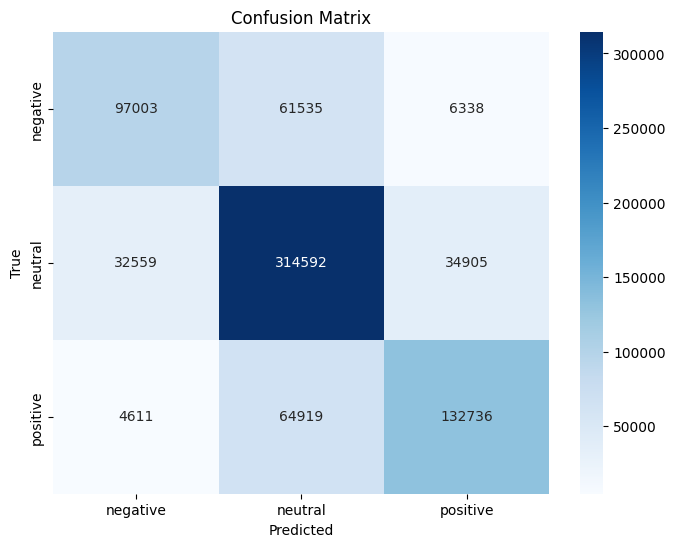

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.7437129616737366     │
│          test_f1          │    0.7412844300270081     │
│         test_loss         │    0.6669178605079651     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6669178605079651, 'test_accuracy': 0.7437129616737366, 'test_f1': 0.7412844300270081}]


In [ ]:


train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['Sentiment'], random_state=rand_seed)
val_df, test_df = train_test_split(temp_df, test_size=0.2, stratify=temp_df['Sentiment'], random_state=rand_seed)

train_dataset = SentimentDataset(train_df)
val_dataset = SentimentDataset(val_df, vocab=train_dataset.vocab)
test_dataset = SentimentDataset(test_df, vocab=train_dataset.vocab)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=0)

model = SentimentRNN(vocab_size=len(train_dataset.vocab) + 1,
                     embedding_dim=EMBEDDING_DIM,
                     hidden_dim=HIDDEN_DIM,
                     output_dim=OUTPUT_DIM,
                     n_layers=2,
                     dropout=0.5,
                     bidirectional=True)

trainer = pl.Trainer(max_epochs=N_EPOCHS, devices=1 if torch.cuda.is_available() else 0)
trainer.fit(model, train_loader, val_loader)

# Test the model
test_results = trainer.test(model, dataloaders=test_loader)
print(test_results)


- Naive Bayes tiene la menor precisión (0.61), mientras que RNN, LSTM y GRU tienen valores más altos y similares (0.71-0.73), con LSTM y GRU superando a RNN.
- El macro promedio del F1-Score muestra una mejora progresiva de Naive Bayes (0.50) hacia RNN (0.69), y los mejores resultados provienen de LSTM (0.73) y GRU (0.72).
- Tanto el modelo LSTM como GRU ofrecen una precisión y recall similares, lo que indica que estos modelos son más consistentes en las predicciones en comparación con Naive Bayes y RNN, especialmente en categorías de sentimiento negativo.